# Interpreting Convolutional Kernels

This example shows how to analyze kernel activations for given input texts or with hypothetical word sequences.
The example is based on our previous IMDB movie review sentiment classification notes. The relevant information starts from the NN model definition, reading the data and pretrained word embeddings is identical/similar to what we have seen previously.

### Read data

In [2]:
import json
import random
with open("data/reuters_51cls.json") as f: #muutettu imdb --> reuters (ei taida toimia)
    data=json.load(f)
random.shuffle(data) 
print(data[0])

# We need to gather the texts, into a list
texts=[one_example["text"] for one_example in data]
labels=[one_example["class"] for one_example in data]
print(texts[:2])
print(labels[:2])

{'text': '&#2;\n******CHEMICAL BANK CUTS PRIME RATE TO 9.25 PCT FROM 9.75 PCT, EFFECTIVE IMMEDIATELY\nBlah blah blah.\n&#3;', 'class': 'interest'}
['&#2;\n******CHEMICAL BANK CUTS PRIME RATE TO 9.25 PCT FROM 9.75 PCT, EFFECTIVE IMMEDIATELY\nBlah blah blah.\n&#3;', '&#2;\nUNICORP CANADA&lt;UNI.A> CUTS PUROLATOR&lt;PCC> STAKE\nWASHINGTON, March 4 - Unicorp Canada Corp told the\nSecurities and Exchange Commission it cut its stake in\nPurolator Courier Corp to 286,500 shares, or 3.7 pct of the\ntotal outstanding, from 962,400 shares, or 12.4 pct.\nUnicorp, a management and investment holding company\ncontrolled by its chairman, George Mann, said it sold 675,900\nPurolator common shares on March 2 and 3 at 34.782 and 34.750\ndlrs a share.\nPurolator agreed this past weekend to be acquired by\nmanagers of its U.S. courier business and E.F. Hutton LBO Inc\nin a leveraged buyout valued at 265 mln dlrs.\nReuter\n&#3;']
['interest', 'acq']


### Use gensim to read the embedding model

In [3]:
from gensim.models import KeyedVectors

vector_model=KeyedVectors.load_word2vec_format("/home/bio/wiki-news-300d-1M.vec", binary=False, limit=20000)
#(muokattu: ennen "/data/wiki..")

# sort based on the index to make sure they are in the correct order
words=[k for k,v in sorted(vector_model.vocab.items(), key=lambda x:x[1].index)]
print("Words from embedding model:",len(words))
print("First 50 words:",words[:50])

Words from embedding model: 20000
First 50 words: [',', 'the', '.', 'and', 'of', 'to', 'in', 'a', '"', ':', ')', 'that', '(', 'is', 'for', 'on', '*', 'with', 'as', 'it', 'The', 'or', 'was', "'", "'s", 'by', 'from', 'at', 'I', 'this', 'you', '/', 'are', '=', 'not', '-', 'have', '?', 'be', 'which', ';', 'all', 'his', 'has', 'one', 'their', 'about', 'but', 'an', '|']


### Normalize the vectors

- Easier to learn on top of these vectors when the magnitude does not vary much

In [4]:
print("Before normalization:",vector_model.get_vector("in")[:10])
vector_model.init_sims(replace=True)
print("After normalization:",vector_model.get_vector("in")[:10])

Before normalization: [-0.0234 -0.0268 -0.0838  0.0386 -0.0321  0.0628  0.0281 -0.0252  0.0269
 -0.0063]
After normalization: [-0.0163762  -0.01875564 -0.05864638  0.02701372 -0.02246478  0.04394979
  0.01966543 -0.0176359   0.01882563 -0.00440898]


### Text analyzer and vectorizer

- When we use an embedding layer (keras.layers.Embedding) the input data must be a sequence, not a bag-of-words vector
- You can use CountVectorizer only as an analyzer without building the feature matrix
- We will then build the vectorizer part later ourselves

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy
analyzer=CountVectorizer(lowercase=False).build_analyzer() # includes tokenizer and preprocessing
print(analyzer(texts[0]))



['CHEMICAL', 'BANK', 'CUTS', 'PRIME', 'RATE', 'TO', '25', 'PCT', 'FROM', '75', 'PCT', 'EFFECTIVE', 'IMMEDIATELY', 'Blah', 'blah', 'blah']


### Expand the vocabulary using words from the embedding model

- The embedding model usually knows more words than the task specific model, because it has seen a lot more data
- If you wish, you can use the embedding model vocabulary to expand the task specific one

In [6]:
# init the vectorizer vocabulary using words from the embedding model
def init_vocabulary(vocab, text, text_analyzer):
    for word in analyzer(text):
        # Only use pretrained vocabulary
        if word in vector_model.vocab:
            vocab.setdefault(word, len(vocab))
    return vocab

words_from_model=" ".join(words[:20000]) # use 20K words from the embedding model to initialize the vocabulary --> expands the learned vocabulary
vocabulary={"<SPECIAL>": 0} # zero has a special meaning in sequence models, prevent using it for a normal word
vocabulary=init_vocabulary(vocabulary, words_from_model, analyzer)
print("Words from embedding model:",len(vocabulary))


Words from embedding model: 19497


### Vectorizer

- Build a dictionary to turn words into numbers, here we use the one which we initialized with the embedding model
- Vectorizing a sequence: In our data each example is a list of words, we need to turn each example into list of numbers

In [7]:
def vectorizer(vocab, texts):
    vectorized_data=[] # turn text into numbers based on our vocabulary mapping
    for one_example in texts:
        vectorized_example=[]
        for word in analyzer(one_example):
            # Only use pretrained vocabulary
            if word in vector_model.vocab:
                vectorized_example.append(vocab[word])
            #vocab.setdefault(word, len(vocab)) # add word to our vocabulary if it does not exist
            #vectorized_example.append(vocab[word])
        vectorized_data.append(vectorized_example)
    
    vectorized_data=numpy.array(vectorized_data) # turn python list into numpy matrix
    return vectorized_data, vocab

vectorized_data, vocabulary=vectorizer(vocabulary, texts)

# now vectorized data is the same as feature_matrix, but in different format
print("Words in vocabulary:",len(vocabulary))
print("Vectorized data shape:",vectorized_data.shape)
print("First example vectorized:",vectorized_data[0])
inversed_vocabulary={value:key for key, value in vocabulary.items()} # inverse the dictionary
print("First example text:",[inversed_vocabulary[idx] for idx in vectorized_data[0]])
        

Words in vocabulary: 19497
Vectorized data shape: (9465,)
First example vectorized: [8932, 319, 18599, 3514, 12239, 12239]
First example text: ['TO', '25', 'FROM', '75', 'blah', 'blah']


### Labels into onehot vectors

- Same as in the original BOW classifier

In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder=LabelEncoder() #Turns class labels into integers
one_hot_encoder=OneHotEncoder(sparse=False) #Turns class integers into one-hot encoding
class_numbers=label_encoder.fit_transform(labels)
print("class_numbers shape=",class_numbers.shape)
print("class_numbers",class_numbers)
print("class labels",label_encoder.classes_)
#And now yet the one-hot encoding
classes_1hot=one_hot_encoder.fit_transform(class_numbers.reshape(-1,1))
print("classes_1hot",classes_1hot)


class_numbers shape= (9465,)
class_numbers [21  0 11 ... 11 11 14]
class labels ['acq' 'alum' 'bop' 'carcass' 'cocoa' 'coffee' 'copper' 'cotton' 'cpi'
 'crude' 'dlr' 'earn' 'fuel' 'gas' 'gnp' 'gold' 'grain' 'heat' 'housing'
 'income' 'instal-debt' 'interest' 'ipi' 'iron-steel' 'jobs' 'lead' 'lei'
 'livestock' 'lumber' 'meal-feed' 'money-fx' 'money-supply' 'nat-gas'
 'oilseed' 'orange' 'pet-chem' 'potato' 'reserves' 'retail' 'rubber'
 'ship' 'silver' 'strategic-metal' 'sugar' 'tea' 'tin' 'trade' 'veg-oil'
 'wpi' 'yen' 'zinc']
classes_1hot [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Network

- First we need to create an embedding matrix which we can then plug into the neural network
- The embedding matrix must follow the order from the vectorizer

In [9]:
def load_pretrained_embeddings(vocab, embedding_model):
    """ vocab: vocabulary from our data vectorizer, embedding_model: model loaded with gensim """
    pretrained_embeddings=numpy.random.uniform(low=-0.05, high=0.05, size=(len(vocab),embedding_model.vectors.shape[1])) # initialize new matrix (words x embedding dim)
    found=0
    for word,idx in vocab.items():
        if word in embedding_model.vocab:
            pretrained_embeddings[idx]=embedding_model.get_vector(word)
            found+=1
            
    print("Found pretrained vectors for {found} words.".format(found=found))
    return pretrained_embeddings

pretrained=load_pretrained_embeddings(vocabulary, vector_model)
print("Shape of pretrained embeddings:",pretrained.shape)
print("Vector for the word 'in':",pretrained[vocabulary["in"]][:10])


Found pretrained vectors for 19496 words.
Shape of pretrained embeddings: (19497, 300)
Vector for the word 'in': [-0.0163762  -0.01875564 -0.05864638  0.02701372 -0.02246478  0.04394979
  0.01966543 -0.0176359   0.01882563 -0.00440898]


### Sequential input

- Remember how the shape of the input data matrix had undefined number of columns
- Now we must make it into fixed size (same for each example)
- Padding: include zeros until you reach the correct size
- You will hear more about this next week!

In [10]:
import tensorflow as tf
### Only needed for me, not to block the whole GPU, you don't need this stuff
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))
### ---end of weird stuff

from keras.preprocessing.sequence import pad_sequences
print("Old shape:", vectorized_data.shape)
vectorized_data_padded=pad_sequences(vectorized_data, padding='post')
print("New shape:", vectorized_data_padded.shape)
print("First example:", vectorized_data_padded[0])

/home/marsalv/.local/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Old shape: (9465,)
New shape: (9465, 970)
First example: [ 8932   319 18599  3514 12239 12239     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0 

A simple network with a single convolutional layer with window size of 2 words (bigrams), 50 kernels and global max pooling (only the maximum value from each kernel is preserved). We create a separate model with the CNN layer as the output. This model shares weights with the actual model and can be used in analysing the kernel activations in each time step.

In [12]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Activation, Conv1D, GlobalMaxPooling1D
from keras import backend as K
from keras.layers.core import Lambda
from keras.optimizers import SGD, Adam


example_count,sequence_len=vectorized_data_padded.shape
example_count,class_count=classes_1hot.shape

vector_size=pretrained.shape[1] # embedding dim ("hidden layer") must be the same as in the pretrained model
kernels = 20
window_size = 2 # How many words a kernel sees at a time

inp=Input(shape=(sequence_len,))
embeddings=Embedding(len(vocabulary), vector_size, mask_zero=False, weights=[pretrained], trainable=False)(inp)
cnn = Conv1D(kernels,window_size,padding='valid',activation='relu',strides=1)(embeddings)
pooling = GlobalMaxPooling1D()(cnn)
outp=Dense(class_count, activation="softmax")(pooling)
model=Model(inputs=[inp], outputs=[outp])

optimizer=Adam(lr=0.001) # define the learning rate
model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=['accuracy'])

# This is our model for outputting the time step wise kernel activations.
cnn_out_model=Model(inputs=[inp], outputs=[cnn])
# We have to compile the model, but we nerver train it directly
cnn_out_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])

print(model.summary())

# train
hist=model.fit(vectorized_data_padded,classes_1hot,batch_size=50,verbose=1,epochs=6,validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 970)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 970, 300)          5849100   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 969, 20)           12020     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 51)                1071      
Total params: 5,862,191
Trainable params: 13,091
Non-trainable params: 5,849,100
_________________________________________________________________
None
Train on 8518 samples, validate on 947 samples
Epoch 1/6
8518/8518 [==============================] - 63s 7ms/step - loss:

Things to note:
1. We are using ReLU activation as it simplifies our life
2. The word embeddings are now fixed, i.e. the training algorithm is not allowed to change the pretrained embeddings

History: [0.5649419268307992, 0.6135163749032186, 0.7001056020967308, 0.7127771916963482, 0.7201689624610144, 0.7360084515061021]
Max accuracy: 0.7360084515061021


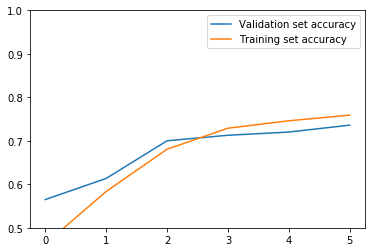

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
print("History:",hist.history["val_acc"])
print("Max accuracy:",numpy.max(hist.history["val_acc"]))
plt.ylim(0.50,1.0)
plt.plot(hist.history["val_acc"],label="Validation set accuracy")
plt.plot(hist.history["acc"],label="Training set accuracy")
plt.legend()
plt.show()

Lets make predictions for the whole training and validation data to see what type of bigrams each kernel has learnt to recognize.

In [14]:
input_data = hist.validation_data[0] # Use vectorized_data_padded if you want activations for the training data as well
predictions = cnn_out_model.predict(input_data, verbose=1, batch_size=64)
print("Predictions shape:", predictions.shape)

947/947 [==============================] - 3s 3ms/step
Predictions shape: (947, 969, 20)


In [15]:
word_embeddings = model.layers[1].get_weights()[0]
print("Word embeddings from the model:", word_embeddings.shape)
print("Kernels:", model.layers[2].get_weights()[0].shape)
for kernel_index in range(model.layers[2].get_weights()[0].shape[-1]):
    kernel = model.layers[2].get_weights()[0][:,:,kernel_index] + model.layers[2].get_weights()[1][kernel_index]

    # Hypothetical highest activations
    activations = numpy.dot(kernel, word_embeddings.T)
    best_word_indices = numpy.argmax(activations, axis=-1)
    
    # Highest activations seen in the validation data
    max_time_steps = numpy.argmax(predictions[:,:,kernel_index], axis=-1)
    max_activations = numpy.max(predictions[:,:,kernel_index], axis=-1)
    best_sentences = numpy.argsort(-max_activations)
    
    best_ngrams = [input_data[best_sentences[nth]][max_time_steps[best_sentences[nth]]:max_time_steps[best_sentences[nth]]+window_size] for nth in range(10)]
    best_ngrams = [' '.join([inversed_vocabulary[i] for i in best]) for best in best_ngrams]
    best_ngrams = ' | '.join(best_ngrams)
 
    print('Kernel %s:' % kernel_index)
    print(best_ngrams)
    print('Hypothetical maximum activation %s:' % kernel_index, ' '.join([inversed_vocabulary[wi] for wi in best_word_indices]), numpy.max(activations, axis=-1), '\n')

Word embeddings from the model: (19497, 300)
Kernels: (2, 300, 20)
Kernel 0:
net loss | net loss | net loss | net loss | net loss | net loss | net loss | net loss | net loss | net loss
Hypothetical maximum activation 0: net loss [1.7489415 2.5665832] 

Kernel 1:
trade deficit | trade deficit | trade deficit | trade deficit | trade deficit | trade deficit | trade deficit | trade deficit | trade deficit | trade deficit
Hypothetical maximum activation 1: trade rates [3.418724  1.9348184] 

Kernel 2:
OF blah | OF blah | OF blah | OF blah | OF blah | OF blah | OF blah | FOR blah | FOR blah | FOR blah
Hypothetical maximum activation 2: FOR blah [0.7164392  0.96077096] 

Kernel 3:
the acquisition | the acquisition | the acquisition | the acquisition | the acquisition | the acquisition | the acquisition | the acquisition | the acquisition | the acquisition
Hypothetical maximum activation 3: outstanding acquisition [0.79193604 3.0611641 ] 

Kernel 4:
said He | said He | said He | said He | said

Lets have a look at some of the kernels, e.g. kernel 10:

Worst script | incoherent script | worst acting | worst acting | worst acting | abysmal screenplay | worst written | poorly scripted | poorly filmed | poorly directed
Hypothetical maximum activation 10: worst script [1.0209291 0.7113825]

* The activating bigram seems to be a negative adjective and a movie related concept
* The hypothetical maximum activation we can generate with the given vocabulary is "worst script", which is very close to the first actual hit, however, this is not always the case:

Kernel 13:
movie sorry | movie Sorry | movie Oh | movie Oh | movie Oh | movie oh | movie oh | movie fails | movie fails | movie fails

Hypothetical maximum activation 13: porn oops [0.6134886 1.025104 ]

Sometimes the kernels are uninterpretable or they make unrealistic assumptions about the the shape of the word embedding space.

* Window size does not force the kernel to learn certain length n-grams (only sets an upper boundary):

Kernel 19:
Great soundtrack | Great film | Great film | great soundtrack | great soundtrack | Great movie | Great Movies | great film | great film | great film

Hypothetical maximum activation 19: Great worksheets [1.0821922 0.6044347]

If we look at the maximum activations for each slot in the above kernel, we notice that the first word has almost twice as high activation as the second one. This means that basically the first word has to be "great" and the second word can be almost anything, i.e. the kernel is only detecting unigrams.

* Looking at the kernel activations does not tell us anything about the kernel importance or relatedness to a certain output (e.g. positive review). To analyze these aspects of the network we have to look into the dense layers following the convolutional layer. This, however, is not straightforward as both CNN kernel activation strengths and dense layer weights should be analyzed together.